In [1]:
 cd /content/drive/My Drive/Xray report generation 

/content/drive/My Drive/Xray report generation


In [2]:
ls

 AttentionModel.ipynb                           Medical.csv
 Basic_Model.ipynb                              model_1_plot.png
 brucechou1983_CheXNet_Keras_0.3.0_weights.h5   NLMCXR_png/
 checkpoints/                                  'Old Files'/
 Chexnetmodel/                                  o_test.pkl
'Copy of AttentionModel.ipynb'                  preprocessed.csv
'Copy of SimpleModel.ipynb'                     saved_model/
 dup_preprocessed.csv                           simple_encoder_decoder_plot.png
 ecgen-radiology/                               SimpleModel.ipynb
 image_feature_vector1.pkl                      tokenizer1.pkl
 indiana_projections.csv                        Untitled0.ipynb
 i_test.pkl                                     Untitled1.ipynb
 logs/                                          Untitled2.ipynb
 logs7/


In [3]:
import re
import pandas as pd
import matplotlib.pyplot as plt
import string
from sklearn.utils import shuffle 
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import numpy as np
import tensorflow as tf
import nltk

In [ ]:
df = pd.read_csv('Medical.csv')

In [ ]:
df.head()

,image_name,image_caption,comparison,indication,findings,impression,findings_count,impression_count,image_count
0,"CXR1_1_IM-0001-3001.png,CXR1_1_IM-0001-4001.png",xray chest pa and lateral,none,positive tb test,the cardiac silhouette and mediastinum size ar...,normal chest x,33,3,2
1,"CXR10_IM-0002-2001.png,CXR10_IM-0002-1001.png",pa and lateral chest x,chest radiographs,male chest pain,the cardiomediastinal silhouette is within nor...,no acute cardiopulmonary process,38,4,2
2,"CXR100_IM-0002-1001.png,CXR100_IM-0002-2001.png",chest v frontallateral pm,none,no indication,both lungs are clear and expanded heart and me...,no active disease,10,3,2
3,"CXR1000_IM-0003-1001.png,CXR1000_IM-0003-2001....",pa and lateral chest x,pa and lateral chest radiographs,male,there is increased opacity within the right up...,increased opacity in the right upper lobe with...,52,36,3
4,"CXR1001_IM-0004-1001.png,CXR1001_IM-0004-1002.png",chest v frontallateral pm,none,dyspnea subjective fevers arthritis immigrant ...,interstitial markings are diffusely prominent ...,diffuse fibrosis no visible focal acute disease,14,7,2


In [ ]:
for item in tqdm(df.iterrows()):
  print(item[1])
  break

0it [00:00, ?it/s]

image_name            CXR1_1_IM-0001-3001.png,CXR1_1_IM-0001-4001.png
image_caption                               xray chest pa and lateral
comparison                                                       none
indication                                           positive tb test
findings            the cardiac silhouette and mediastinum size ar...
impression                                             normal chest x
findings_count                                                     33
impression_count                                                    3
image_count                                                         2
Name: 0, dtype: object


In [ ]:
df_projections = pd.read_csv('indiana_projections.csv')

In [ ]:
df_projections.head()

,uid,filename,projection
0,1,1_IM-0001-4001.dcm.png,Frontal
1,1,1_IM-0001-3001.dcm.png,Lateral
2,2,2_IM-0652-1001.dcm.png,Frontal
3,2,2_IM-0652-2001.dcm.png,Lateral
4,3,3_IM-1384-1001.dcm.png,Frontal


In [ ]:
img_path = 'NLMCXR_png/'

In [ ]:
# to find the matching pattern in a string - https://thepythonguru.com/python-regular-expression/
def find_fr_lr_images(li):
  """
  This funct is used to find the lateral images and frontal images from our list of images
  """
  img_list = []
  last_imag = ""
  for img in li:
    projections = df_projections[df_projections['filename'].str.contains(re.search(r"\d.*\_IM-\d.*\.",img).group())]['projection'].values
    if 'Lateral'== projections:
      last_imag = img
    else:
      img_list.append(img)
  return img_list, last_imag

In [ ]:
#Creating structured data from raw xml files
columns = ["image_1", "image_2", "impression"]
df_1 = pd.DataFrame(columns = columns)
columns = ["image_1", "image_2", "impression"]
df_dup = pd.DataFrame(columns = columns)
no_lateral = 0
for item in tqdm(df.iterrows()):
    l = item[1]['image_name'].split(',')
    if len(l) > 2:
        li, last_img = find_fr_lr_images(l)
        if last_img == "":
            no_lateral +=1
            li, last_img = li[:-1], li[-1]
        for i in li:
            image_1 = i
            image_2 = last_img
            df_1 = df_1.append(pd.Series([image_1, image_2,item[1]['findings']], index = columns), ignore_index = True)
    elif len(l) == 2:
        image_1 = l[0] 
        image_2 = l[1]
        df_1 = df_1.append(pd.Series([image_1, image_2, item[1]['findings']], index = columns), ignore_index = True)
    elif len(l) == 1:
        #creating duplicate dataframe separately to keep it in all dataset train test validate
        df_dup = df_dup.append(pd.Series([l[0], l[0],item[1]['findings']], index = columns), ignore_index = True)
print("Total Report without Lateral images {}".format(no_lateral))
     
     



   
     




1130it [00:04, 264.40it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  # Remove the CWD from sys.path while we load stuff.
3851it [00:15, 255.66it/s]

Total Report without Lateral images 1


In [ ]:
df_1.shape

(3532, 3)

In [ ]:
df_1.head()

,image_1,image_2,impression
0,CXR1_1_IM-0001-3001.png,CXR1_1_IM-0001-4001.png,cardiac silhouette mediastinum size within nor...
1,CXR10_IM-0002-1001.png,CXR10_IM-0002-2001.png,cardiomediastinal silhouette within normal lim...
2,CXR100_IM-0002-1001.png,CXR100_IM-0002-2001.png,lungs clear expanded heart mediastinum normal
3,CXR1000_IM-0003-1001.png,CXR1000_IM-0003-2001.png,increased opacity within right upper lobe poss...
4,CXR1000_IM-0003-3001.png,CXR1000_IM-0003-2001.png,increased opacity within right upper lobe poss...


In [ ]:
df_dup.shape

(446, 3)

In [ ]:
df_dup.head()

,image_1,image_2,impression
0,CXR1003_IM-0005-2002.png,CXR1003_IM-0005-2002.png,heart size pulmonary vascularity appear within...
1,CXR1012_IM-0013-1001.png,CXR1012_IM-0013-1001.png,lung volumes low bibasilar consolidation bilat...
2,CXR1024_IM-0019-1001.png,CXR1024_IM-0019-1001.png,heart size normal lungs clear no focal air spa...
3,CXR1026_IM-0021-2002.png,CXR1026_IM-0021-2002.png,lungs appear clear heart pulmonary appear norm...
4,CXR1029_IM-0022-1001.png,CXR1029_IM-0022-1001.png,NaN


Adding Start and end tokens

In [ ]:
def add_start_end_token(data):
    # Combining all the above stundents 
    preprocessed_reviews_eng = []

    # tqdm is for printing the status bar
    for sentance in tqdm(data.values):
        sentance = '<start> ' + sentance + ' <end>'
        preprocessed_reviews_eng.append(sentance.strip())
    return preprocessed_reviews_eng


In [ ]:
df_1['impression'] = add_start_end_token(df_1['impression'].astype(str))

100%|██████████| 3532/3532 [00:00<00:00, 514277.64it/s]


In [ ]:
df_dup['impression'] = add_start_end_token(df_dup['impression'].astype(str))

100%|██████████| 446/446 [00:00<00:00, 376238.85it/s]


In [ ]:
df_1.head()

,image_1,image_2,impression
0,CXR1_1_IM-0001-3001.png,CXR1_1_IM-0001-4001.png,<start> cardiac silhouette mediastinum size wi...
1,CXR10_IM-0002-1001.png,CXR10_IM-0002-2001.png,<start> cardiomediastinal silhouette within no...
2,CXR100_IM-0002-1001.png,CXR100_IM-0002-2001.png,<start> lungs clear expanded heart mediastinum...
3,CXR1000_IM-0003-1001.png,CXR1000_IM-0003-2001.png,<start> increased opacity within right upper l...
4,CXR1000_IM-0003-3001.png,CXR1000_IM-0003-2001.png,<start> increased opacity within right upper l...


In [ ]:
df_dup.head()

,image_1,image_2,impression
0,CXR1003_IM-0005-2002.png,CXR1003_IM-0005-2002.png,<start> heart size pulmonary vascularity appea...
1,CXR1012_IM-0013-1001.png,CXR1012_IM-0013-1001.png,<start> lung volumes low bibasilar consolidati...
2,CXR1024_IM-0019-1001.png,CXR1024_IM-0019-1001.png,<start> heart size normal lungs clear no focal...
3,CXR1026_IM-0021-2002.png,CXR1026_IM-0021-2002.png,<start> lungs appear clear heart pulmonary app...
4,CXR1029_IM-0022-1001.png,CXR1029_IM-0022-1001.png,<start> nan <end>


In [ ]:
df_1.to_csv('preprocessed1.csv')

In [ ]:
df_dup.to_csv('dup_preprocessed1.csv')

In [ ]:
df_1 = pd.read_csv('preprocessed.csv')

In [ ]:
df_1.head()

,Unnamed: 0,image_1,image_2,impression
0,0,CXR1_1_IM-0001-3001.png,CXR1_1_IM-0001-4001.png,<start> normal chest x <end>
1,1,CXR10_IM-0002-2001.png,CXR10_IM-0002-1001.png,<start> no acute cardiopulmonary process <end>
2,2,CXR100_IM-0002-1001.png,CXR100_IM-0002-2001.png,<start> no active disease <end>
3,3,CXR1000_IM-0003-1001.png,CXR1000_IM-0003-2001.png,<start> increased opacity in the right upper l...
4,4,CXR1000_IM-0003-3001.png,CXR1000_IM-0003-2001.png,<start> increased opacity in the right upper l...


In [ ]:
df_dup  = pd.read_csv('dup_preprocessed.csv')

In [ ]:
df_dup.head()

,Unnamed: 0,image_1,image_2,impression
0,0,CXR1003_IM-0005-2002.png,CXR1003_IM-0005-2002.png,<start> retrocardiac soft tissue density the a...
1,1,CXR1012_IM-0013-1001.png,CXR1012_IM-0013-1001.png,<start> bibasilar airspace disease and bilater...
2,2,CXR1024_IM-0019-1001.png,CXR1024_IM-0019-1001.png,<start> no acute abnormality <end>
3,3,CXR1026_IM-0021-2002.png,CXR1026_IM-0021-2002.png,<start> no acute cardiopulmonary disease <end>
4,4,CXR1029_IM-0022-1001.png,CXR1029_IM-0022-1001.png,<start> no pneumonia heart size normal scolios...


In [ ]:
df_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3532 entries, 0 to 3531
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  3532 non-null   int64 
 1   image_1     3532 non-null   object
 2   image_2     3532 non-null   object
 3   impression  3532 non-null   object
dtypes: int64(1), object(3)
memory usage: 110.5+ KB


In [ ]:
# df_1.drop("Unnamed: 0",axis='columns',inplace=True)

In [ ]:
image_names = []
for img in tqdm(df['image_name'].str.split(',')):
  
 
  for i in range(len(img)):
    image_names.append(img[i])


100%|██████████| 3851/3851 [00:00<00:00, 560278.36it/s]


In [ ]:
image_names[0:4]

['CXR1_1_IM-0001-3001.png',
 'CXR1_1_IM-0001-4001.png',
 'CXR10_IM-0002-2001.png',
 'CXR10_IM-0002-1001.png']

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import densenet
from tensorflow.keras.applications.densenet import preprocess_input
from tensorflow.keras.layers import Dense, Dropout,Input,Conv2D
from tensorflow.keras.models import Model

In [ ]:
## the input layer shape is (None,None,None,3)
## the output layer is (None,2048)

In [ ]:
chex = densenet.DenseNet121(include_top=False,weights=None,input_shape=(224,224,3),pooling="avg")
X = chex.output
X = Dense(14,activation='sigmoid',name='predictions')(X)
model = Model(inputs=chex.input,outputs=X)
model.load_weights('brucechou1983_CheXNet_Keras_0.3.0_weights.h5')
image_features_model = Model(inputs=model.input,outputs= model.layers[-2].output)

In [ ]:
import pickle 
with open('image_feature_vector1.pkl','rb') as f:
  image_feature_vector_1 = pickle.load(f)

In [ ]:
print(image_feature_vector_1[1])

tf.Tensor(
[[5.0062913e-04 2.0340595e-03 1.2797897e-03 ... 9.1456938e-01
  9.2038012e-01 7.4285048e-01]], shape=(1, 1024), dtype=float32)


Train, Validation and Test split

In [ ]:
i_train,input_test,o_train,output_test = train_test_split(df_1[['image_1','image_2']].values,df_1['impression'].values,test_size=0.1,random_state=15)
input_train,input_validate,output_train,output_validate = train_test_split(i_train,o_train,test_size=0.2,random_state=15)

In [ ]:
input_train.shape,input_validate.shape,input_test.shape,output_train.shape,output_validate.shape,output_test.shape

((2542, 2), (636, 2), (354, 2), (2542,), (636,), (354,))

In [ ]:
i_train_dup,input_test_dup,o_train_dup,output_test_dup = train_test_split(df_dup[['image_1','image_2']].values,df_dup['impression'].values,test_size=0.1,random_state=15)
input_train_dup,input_validate_dup,output_train_dup,output_validate_dup = train_test_split(i_train_dup,o_train_dup,test_size=0.2,random_state=15)

In [ ]:
input_train_dup.shape,input_validate_dup.shape,input_test_dup.shape,output_train_dup.shape,output_validate_dup.shape,output_test_dup.shape

((320, 2), (81, 2), (45, 2), (320,), (81,), (45,))

Appending the duplicate data and the original data

In [ ]:
i_train = np.append(input_train,input_train_dup,axis=0)
o_train = np.append(output_train,output_train_dup,axis=0)
i_validate = np.append(input_validate,input_validate_dup,axis=0)
o_validate = np.append(output_validate,output_validate_dup,axis=0)
i_test = np.append(input_test,input_test_dup,axis=0)
o_test = np.append(output_test,output_test_dup,axis=0)


In [ ]:
i_train[0]

array(['CXR914_IM-2417-1001.png', 'CXR914_IM-2417-3001.png'], dtype=object)

In [ ]:
#https://datascience.stackexchange.com/questions/24511/why-should-the-data-be-shuffled-for-machine-learning-tasks
# Here we will be shuffling the data 
for i in range(5):
  i_train,o_train = shuffle(i_train,o_train,random_state=15)
  i_validate,o_validate = shuffle(i_validate,o_validate,random_state=15)
  i_test,o_test = shuffle(i_test,o_test,random_state=15)

TEXT TOKENIZATION

In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

max_length_output = 60

tokenizer = Tokenizer(oov_token="<unk>", filters='!"#$%&()*+.,-/:;=?@[\]^_`{|}~ ')
tokenizer.fit_on_texts(o_train)
text_train = tokenizer.texts_to_sequences(o_train)
text_validation = tokenizer.texts_to_sequences(o_validate)
text_test = tokenizer.texts_to_sequences(o_test)

In [ ]:
import pickle

with open('tokenizer1.pkl','wb') as f:
  pickle.dump(tokenizer,f)

In [ ]:
dictionary = tokenizer.word_index

In [ ]:
word2idx = {}
idx2word = {}
for k,v in dictionary.items():
  word2idx[k] = v # put the word value for the particular key(index)
  idx2word[v] = k # put the particular index for the word


In [ ]:
vocabulary_size = len(word2idx)+1
print(vocabulary_size)

1339


In [ ]:
print("===== Top 6 Word and its Index =====")
list(dictionary.items())[:6]

===== Top 6 Word and its Index =====


[('<unk>', 1),
 ('<start>', 2),
 ('<end>', 3),
 ('no', 4),
 ('acute', 5),
 ('cardiopulmonary', 6)]

In [ ]:
## Padding the text 
text_train_output = pad_sequences(text_train,maxlen=60,dtype='int32',padding='post',truncating='post')
text_validation_output = pad_sequences(text_validation,maxlen=60,dtype='int32',padding='post',truncating='post')
text_test_output = pad_sequences(text_test,maxlen=60,dtype='int32',padding='post',truncating='post')

In [ ]:
text_train_output.shape

(2862, 60)

Creating Tensorflow Dataset

In [ ]:
# converting the numpy image files into tensorformats

def multi_image(img,imp):
  """
  This function will be taking in the imgaes we have and converting into tensor format and return the impression and the imgaes.
  """
  return tf.convert_to_tensor([image_feature_vector_1[image_names.index(img[0].decode('utf-8'))],image_feature_vector_1[image_names.index(img[1].decode('utf-8'))]]),imp

In [ ]:
dataset_train = tf.data.Dataset.from_tensor_slices((i_train,text_train_output))

In [ ]:
dataset_validation = tf.data.Dataset.from_tensor_slices((i_validate,text_validation_output))

In [ ]:
dataset_train = dataset_train.map(lambda item1,item2: tf.numpy_function(multi_image,[item1,item2],[tf.float32,tf.int32]),num_parallel_calls=tf.data.experimental.AUTOTUNE) 
dataset_validation = dataset_validation.map(lambda item1,item2: tf.numpy_function(multi_image,[item1,item2],[tf.float32,tf.int32]),num_parallel_calls=tf.data.experimental.AUTOTUNE)

In [ ]:
BATCH_SIZE = 32
BUFFER_SIZE = 1000
embedding_dimension = 256
units = 128 # output

In [ ]:
# Shuffle and Batch 
dataset_train = dataset_train.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
dataset_train = dataset_train.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

#Shuffle and Batch
dataset_validation = dataset_validation.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
dataset_validation = dataset_validation.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

In [ ]:
# input_shape is (2,1,2048)
# vocab_size = 1337

Encoder Decoder Model

In [ ]:
class BahdanauAttention(tf.keras.Model):
  def __init__(self,units):
    super(BahdanauAttention, self).__init__()
    self.w1 = tf.keras.layers.Dense(units)
    self.w2 = tf.keras.layers.Dense(units)
    self.v  = tf.keras.layers.Dense(1)

  def call(self,features, hidden):
    

      ## features(Encoder output) shape == (batch_size,64,embedding_dim)
      ## hidden shape == (batch_size, hidden_size)
      ## hidden_with_time_axis == (batch_size, 1, hidden_size)

    hidden_with_time_axis = tf.expand_dims(hidden, 1)

      # attention_hidden_layer shape == (batch_size,49,units)

    attention_hidden_layer = (tf.nn.tanh(self.w1(features)+ self.w2(hidden_with_time_axis)))

      # socre shape == (batch_size,64,1)
      # This gives an unnormalized score for each image feature.
    score = self.v(attention_hidden_layer)
    attention_weights = tf.nn.softmax(score,axis=1)

      # context_vector shape after sum == (batch_size,hidden_size)
    context_vector = attention_weights * features
    context_vector = tf.reduce_sum(context_vector,axis=1)

    return context_vector, attention_weights


In [ ]:
class Encoder(tf.keras.Model):
    def __init__(self, embedding_dim):
        super(Encoder, self).__init__()
        self.dense = tf.keras.layers.Dense(embedding_dim, activation='relu', kernel_initializer=tf.keras.initializers.glorot_uniform(seed=45))
        self.concat = tf.keras.layers.Concatenate()
    def call(self, x):
        
        encoder_concat = self.concat([x[:,0], x[:,1]])
        x = self.dense(encoder_concat)
        x = tf.nn.relu(x)
        return x


In [ ]:
class RNN_Decoder(tf.keras.Model):
  def __init__(self,embedding_dim,units,vocab_size):
    super(RNN_Decoder,self).__init__()
    self.units = units

    self.embedding = tf.keras.layers.Embedding(vocab_size,embedding_dim)
    self.gru = tf.keras.layers.GRU(self.units,return_sequences=True,return_state=True,recurrent_initializer='glorot_uniform')
    self.fc1 = tf.keras.layers.Dense(self.units)
    self.fc2 = tf.keras.layers.Dense(vocab_size)
    self.attention = BahdanauAttention(self.units)

  def call(self,x,features,hidden):

      #defining attention as a separate model
    context_vector, attention_weights = self.attention(features,hidden)
      # shape of x after embedding (batch_size,1, embedding_dimension)
    x  = self.embedding(x)
      # shape of x after concatenation (batch_size,1,ebedding_dimension + hidden_size)
    x  = tf.concat([tf.expand_dims(context_vector,1), x],axis=-1)

      # passing the concatenated vector to the GRU 

    output, state = self.gru(x)

      # shape == (batch_size,max_length, hidden_size)
    x  = self.fc1(output)

      # shape  == (batch_size*max_length, hidden_size)
    x = tf.reshape(x,(-1,x.shape[2]))

      # output shape == (batch_size * max_length,vocab)

    x = self.fc2(x)

    return x, state, attention_weights
    
    


In [ ]:
encoder = Encoder(embedding_dimension)
decoder = RNN_Decoder(embedding_dimension,units,vocabulary_size)


In [ ]:
# modelling loss and accuracy for gradient tape based on this https://www.tensorflow.org/tutorials/quickstart/advanced.

optimizer = tf.keras.optimizers.Adam()
loss_obj  = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')
acc_obj   = tf.keras.metrics.SparseCategoricalAccuracy()

def loss_func(real,pred):
  mask = tf.math.logical_not(tf.math.equal(real,0))
  loss_ = loss_obj(real,pred)

  mask = tf.cast(mask,dtype=loss_.dtype)
  loss_ *= mask

  return tf.reduce_mean(loss_)

def acc_func(real,pred):
  acc_f = acc_obj(real,pred)
  return tf.reduce_mean(acc_f)



In [ ]:
checkpoint_path = "./checkpoints/train"
ckpt = tf.train.Checkpoint(encoder=encoder,decoder=decoder,optimizer=optimizer)

ckpt_manager = tf.train.CheckpointManager(ckpt,checkpoint_path,max_to_keep=5)
 


In [ ]:
start_epoch = 0
if ckpt_manager.latest_checkpoint:
  start_epoch = int(ckpt_manager.latest_checkpoint.split('-')[-1])
  # restoring the latest checkpoint in checkpoint_path
  ckpt.restore(ckpt_manager.latest_checkpoint)

In [ ]:
import datetime
current_time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
train_log_dir = 'logs7/Basic_gradient_tape/' + current_time +'/train'
validation_log_dir = 'logs7/Basic_gradient_tape/'+ current_time +'/test'
train_summary_writer = tf.summary.create_file_writer(train_log_dir)
validation_summary_writer = tf.summary.create_file_writer(validation_log_dir)


MODEL Training 

In [ ]:
@tf.function 
def train_step(img_tensor,target):
  """Train Step"""
  loss = 0
  accuracy = 0 
  hidden = tf.zeros((target.shape[0],units))
  dec_input = tf.expand_dims([tokenizer.word_index['<start>']]*target.shape[0],1)

  with tf.GradientTape() as tape:
    features = encoder(img_tensor)

    for i in range(1,target.shape[1]):
      # passing the features through the decoder 
      predictions, hidden, _ = decoder(dec_input,features,hidden)
      loss += loss_func(target[:,i],predictions)
      accuracy += acc_func(target[:,i],predictions)

      # using teacher forcing 
      dec_input = tf.expand_dims(target[:,i],1)

  total_loss = (loss/int(target.shape[1]))
  total_accuracy = (accuracy/int(target.shape[1]))

  trainable_variables = encoder.trainable_variables + decoder.trainable_variables
  gradients = tape.gradient(loss,trainable_variables)

  optimizer.apply_gradients(zip(gradients,trainable_variables))

  return loss,total_loss,total_accuracy


@tf.function
def val_step(img_tensor,target):
  """Train Step"""
  loss_val = 0
  accuracy_val = 0 
  hidden = tf.zeros((target.shape[0],units))
  dec_input = tf.expand_dims([tokenizer.word_index['<start>']]*target.shape[0],1)

  with tf.GradientTape() as tape:
    features = encoder(img_tensor)

    for i in range(1,target.shape[1]):
      # passing the features through the decoder 
      predictions_val, hidden, _ = decoder(dec_input,features,hidden)
      loss_val += loss_func(target[:,i],predictions_val)
      accuracy_val += acc_func(target[:,i],predictions_val)

      # using teacher forcing 
      dec_input = tf.expand_dims(target[:,i],1)

  total_loss_val = (loss_val/int(target.shape[1]))
  total_accuracy_val = (accuracy_val/int(target.shape[1]))

  

  

  return loss_val,total_loss_val,total_accuracy_val




In [ ]:
EPOCHS = 50
val_loss_history = []
count = 0

for epoch in range(start_epoch,EPOCHS):
  print("================Start Epoch" + str(epoch+1)+ "==========")

  total_loss_train = 0
  total_acc_train  = 0
  total_loss_val   = 0
  total_acc_val    = 0
  print("Train loss")
  for (batch,(img_tensor,target)) in enumerate(dataset_train):
    batch_loss,t_loss,t_acc = train_step(img_tensor,target)
    total_loss_train += t_loss
    total_acc_train  += t_acc 

    if batch% 40 == 0:
      print('Epoch {} Batch{} Loss{:.4f} acc{:.4f}'.format(epoch+1, batch, batch_loss/int(target.shape[1]), t_acc))
  with train_summary_writer.as_default():
    tf.summary.scalar('loss',total_loss_train/int(len(i_train)//BATCH_SIZE),step=epoch)
    tf.summary.scalar('accuracy',total_acc_train/int(len(i_train)//BATCH_SIZE),step=epoch)

  #Validation
  print('Validation Loss')
  for (batch,(img_tensor,target)) in enumerate(dataset_validation):
    batch_loss,v_loss,v_acc = val_step(img_tensor,target)
    total_loss_val += v_loss
    total_acc_val  += v_acc 
    if batch% 40 == 0:
      print('Epoch {} Batch {} Loss{:.4f} acc{:.4f}'.format(epoch+1,batch,batch_loss/int(target.shape[1]),v_acc))
  with validation_summary_writer.as_default():
    tf.summary.scalar('loss',total_loss_val/int(len(i_validate)//BATCH_SIZE),step=epoch)
    tf.summary.scalar('accuracy',total_acc_val/int(len(i_validate)//BATCH_SIZE),step=epoch)

  print('EPOCH {}, LOSS: {}, ACCURACY:{}, TEST LOSS: {}, TEST ACCURACY: {}'.format(epoch+1, total_loss_train/(int(len(i_train)//BATCH_SIZE)),
                                                                                   (total_acc_train/(int(len(i_train)//BATCH_SIZE)))*100,
                                                                                  total_loss_val/(int(len(i_validate)//BATCH_SIZE)),
                                                                                   (total_acc_val/(int(len(i_validate)//BATCH_SIZE)))*100))
  
  val_loss_history.append(total_loss_val/int(len(i_validate)//BATCH_SIZE))
  if epoch > 6:
    if count >= 4:
      print("Early Stopping Invoked!!!! Stopping the training \n\n")
      ckpt_manager.save()
      break
    else:
      if val_loss_history[epoch-1] < val_loss_history[epoch]:
        print("\n******count++ Increased******\n")
        count +=1 



================Start Epoch1==========
Train loss
Epoch 1 Batch0 Loss0.6172 acc0.0506
Epoch 1 Batch40 Loss0.4577 acc0.0520
Epoch 1 Batch80 Loss0.5037 acc0.0533
Validation Loss
Epoch 1 Batch 0 Loss0.4995 acc0.0536
EPOCH 1, LOSS: 0.5678637027740479, ACCURACY:5.274105072021484, TEST LOSS: 0.6858891248703003, TEST ACCURACY: 5.631457805633545
================Start Epoch2==========
Train loss
Epoch 2 Batch0 Loss0.4816 acc0.0542
Epoch 2 Batch40 Loss0.3206 acc0.0553
Epoch 2 Batch80 Loss0.5526 acc0.0562
Validation Loss
Epoch 2 Batch 0 Loss0.3706 acc0.0565
EPOCH 2, LOSS: 0.546222984790802, ACCURACY:5.5949859619140625, TEST LOSS: 0.6736574172973633, TEST ACCURACY: 5.928240776062012
================Start Epoch3==========
Train loss
Epoch 3 Batch0 Loss0.7971 acc0.0569
Epoch 3 Batch40 Loss0.4391 acc0.0578
Epoch 3 Batch80 Loss0.3060 acc0.0586
Validation Loss
Epoch 3 Batch 0 Loss1.1458 acc0.0588
EPOCH 3, LOSS: 0.5242691040039062, ACCURACY:5.851855754852295, TEST LOSS: 0.6579887866973877, TEST ACCURACY

Evaluation

In [ ]:
from tensorflow.keras.applications.densenet import preprocess_input
def get_img_tensor(image_path,img_name,model_image):
  img = tf.io.read_file(image_path+str(img_name))
  img = tf.image.decode_jpeg(img,channels=3)
  img = tf.image.resize(img,(224,224))
  img = preprocess_input(img)
  img_features = model_image(tf.constant(img)[None,:])
  return img_features

In [ ]:
def evaluate(img_name):
    
    hidden =  tf.zeros((1, units))
    img_tensor = tf.convert_to_tensor([get_img_tensor(img_path,img_name[0], image_features_model), 
                                      get_img_tensor(img_path,img_name[1], image_features_model)])
    img_features = tf.constant(img_tensor)[None, :]
    features_val = encoder(img_features)

    dec_input = tf.expand_dims([tokenizer.word_index['<start>']], 0)
    result = []
    text = ""
    max_length_output=60
    for i in range(max_length_output):
        predictions, hidden,attention_weights = decoder(dec_input,features_val,hidden)
        predicted_id = tf.random.categorical(predictions,1)[0][0].numpy()
        if predicted_id ==0:
            word = ""
        else:
            word = tokenizer.index_word[predicted_id]
        result.append(word)
        text += " " + word
        if word == '<end>' or word == 'end':
            return result, text

        dec_input = tf.expand_dims([predicted_id], 0)
    return result, text




  

In [ ]:
import matplotlib.image as mpimg
from nltk.translate.bleu_score import sentence_bleu
def test_img_cap(img_data, actual_text):
    result, text = evaluate(img_data)
    """Displays images for given input array of image names"""
    fig, axs = plt.subplots(1, len(img_data), figsize = (10,10), tight_layout=True)
    count = 0
    for img, subplot in zip(img_data, axs.flatten()):
        img_=mpimg.imread(img_path+img)
        imgplot = axs[count].imshow(img_, cmap = 'bone')
        count +=1
    plt.show()
    reference = [actual_text.split()[1:-1]]
    result = result[:-1]
    print("="*50)
    print("Actual", actual_text)
    print("Predicted:",text)
    print("="*50)
    print('Individual 1-gram: {:.4f} Cumulative 1-gram: {:.4f}'.format(sentence_bleu(reference, result, weights=(1, 0, 0, 0)), sentence_bleu(reference, result, weights=(1, 0, 0, 0))))
    print('Individual 2-gram: {:.4f} Cumulative 2-gram: {:.4f}'.format(sentence_bleu(reference, result, weights=(0, 1, 0, 0)), sentence_bleu(reference, result, weights=(0.5, 0.5, 0, 0))))
    print('Individual 3-gram: {:.4f} Cumulative 3-gram: {:.4f}'.format(sentence_bleu(reference, result, weights=(0, 0, 1, 0)), sentence_bleu(reference, result, weights=(0.33, 0.33, 0.33, 0))))
    print('Individual 4-gram: {:.4f} Cumulative 4-gram: {:.4f}'.format(sentence_bleu(reference, result, weights=(0, 0, 0, 1)), sentence_bleu(reference, result, weights=(0.25, 0.25, 0.25, 0.25))))

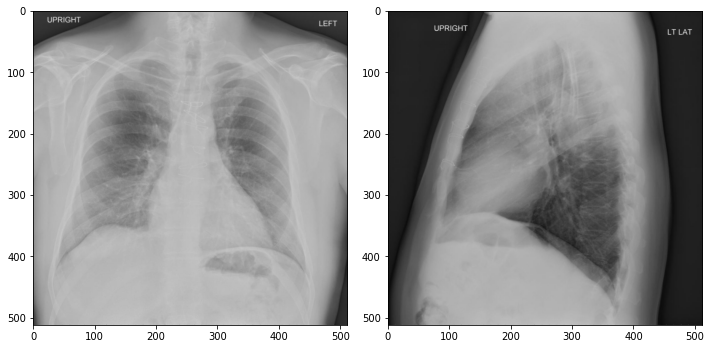

Actual <start> clear lungs no acute cardiopulmonary abnormality <end>
Predicted:  no acute cardiopulmonary disease <end>
Individual 1-gram: 0.4549 Cumulative 1-gram: 0.4549
Individual 2-gram: 0.4044 Cumulative 2-gram: 0.4289
Individual 3-gram: 0.3033 Cumulative 3-gram: 0.3839
Individual 4-gram: 0.6065 Cumulative 4-gram: 0.4289


/usr/local/lib/python3.6/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 4-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


In [ ]:
test_img_cap(i_test[3],o_test[3])

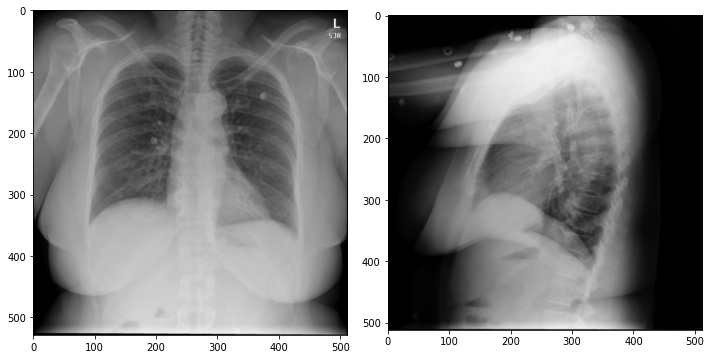

Actual <start> no acute cardiopulmonary disease <end>
Predicted:  mildly negative for todays study although this clips <end>
Individual 1-gram: 0.0000 Cumulative 1-gram: 0.0000
Individual 2-gram: 0.0000 Cumulative 2-gram: 0.0000
Individual 3-gram: 0.0000 Cumulative 3-gram: 0.0000
Individual 4-gram: 0.0000 Cumulative 4-gram: 0.0000


In [ ]:
test_img_cap(i_test[64], o_test[64])

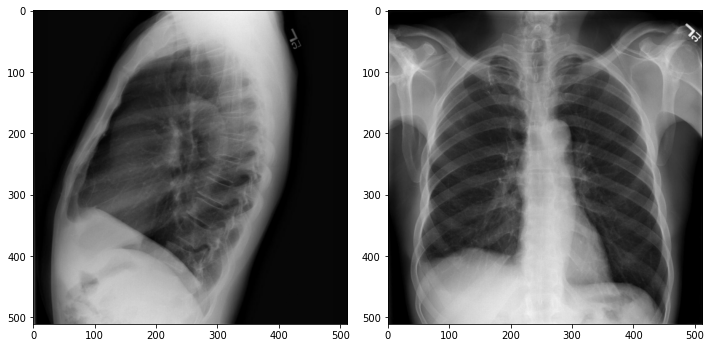

Actual <start> no acute cardiopulmonary disease <end>
Predicted:  no evidence of tuberculosis comparison chest <end>
Individual 1-gram: 0.1667 Cumulative 1-gram: 0.1667
Individual 2-gram: 1.0000 Cumulative 2-gram: 0.4082
Individual 3-gram: 1.0000 Cumulative 3-gram: 0.5536
Individual 4-gram: 1.0000 Cumulative 4-gram: 0.6389


/usr/local/lib/python3.6/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


In [ ]:
test_img_cap(i_test[29], o_test[29])

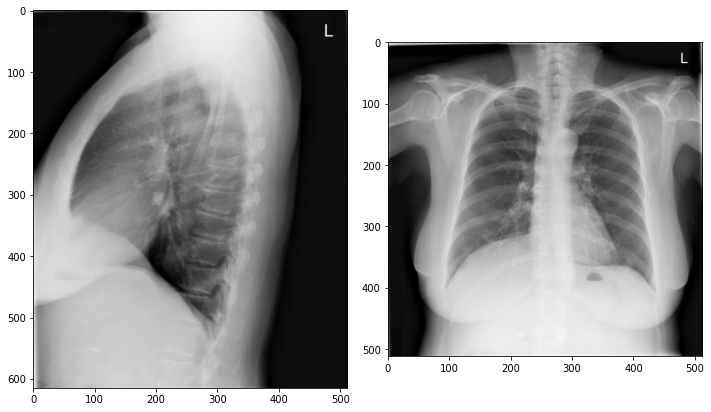

Actual <start> no acute intrathoracic abnormality <end>
Predicted:  no suspicious chest prior available <end>
Individual 1-gram: 0.2000 Cumulative 1-gram: 0.2000
Individual 2-gram: 1.0000 Cumulative 2-gram: 0.4472
Individual 3-gram: 1.0000 Cumulative 3-gram: 0.5879
Individual 4-gram: 1.0000 Cumulative 4-gram: 0.6687


/usr/local/lib/python3.6/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


In [ ]:
test_img_cap(i_test[65], o_test[65])

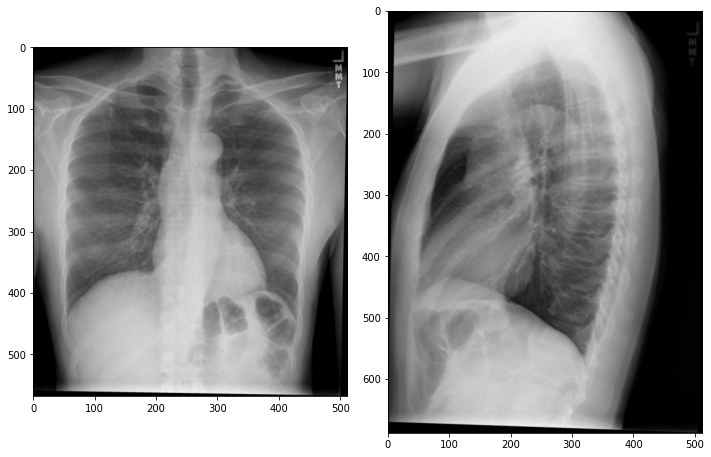

Actual <start> no acute cardiopulmonary process <end>
Predicted:  no acute cardiopulmonary abnormality <end>
Individual 1-gram: 0.7500 Cumulative 1-gram: 0.7500
Individual 2-gram: 0.6667 Cumulative 2-gram: 0.7071
Individual 3-gram: 0.5000 Cumulative 3-gram: 0.6329
Individual 4-gram: 1.0000 Cumulative 4-gram: 0.7071


/usr/local/lib/python3.6/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 4-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


In [ ]:
test_img_cap(i_test[103], o_test[103])

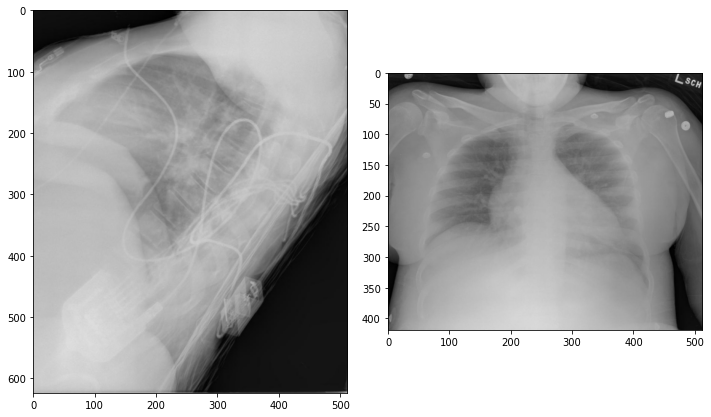

Actual <start> no active disease <end>
Predicted:  no acute pulmonary edema <end>
Individual 1-gram: 0.2500 Cumulative 1-gram: 0.2500
Individual 2-gram: 1.0000 Cumulative 2-gram: 0.5000
Individual 3-gram: 1.0000 Cumulative 3-gram: 0.6329
Individual 4-gram: 1.0000 Cumulative 4-gram: 0.7071


/usr/local/lib/python3.6/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


In [ ]:
test_img_cap(i_test[363], o_test[363])

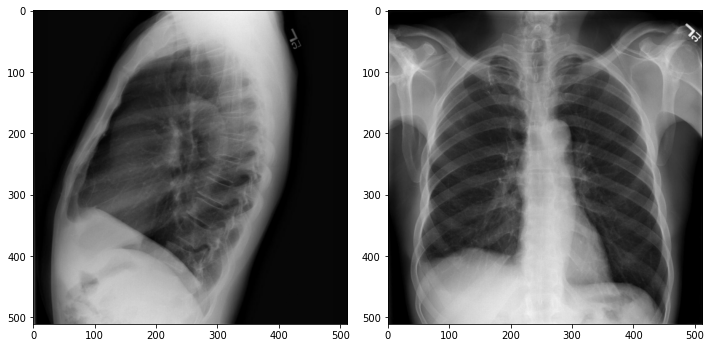

Actual <start> no acute cardiopulmonary disease <end>
Predicted:  hypoinflation with the the lung nodules or scarring <end>
Individual 1-gram: 0.0000 Cumulative 1-gram: 0.0000
Individual 2-gram: 0.0000 Cumulative 2-gram: 0.0000
Individual 3-gram: 0.0000 Cumulative 3-gram: 0.0000
Individual 4-gram: 0.0000 Cumulative 4-gram: 0.0000


In [ ]:
test_img_cap(i_test[29], o_test[29])

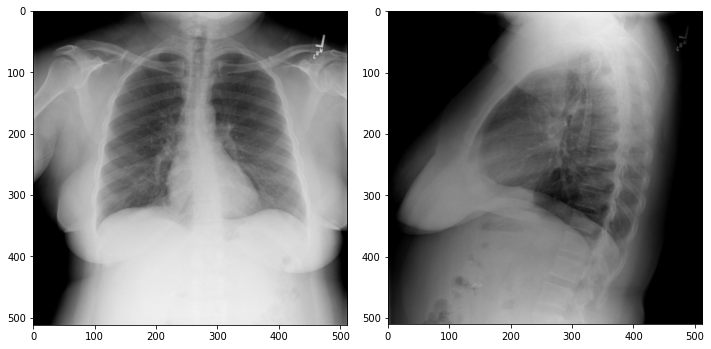

Actual <start> no acute cardiopulmonary abnormality <end>
Predicted:  no acute cardiopulmonary process <end>
Individual 1-gram: 0.7500 Cumulative 1-gram: 0.7500
Individual 2-gram: 0.6667 Cumulative 2-gram: 0.7071
Individual 3-gram: 0.5000 Cumulative 3-gram: 0.6329
Individual 4-gram: 1.0000 Cumulative 4-gram: 0.7071


/usr/local/lib/python3.6/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 4-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


In [ ]:
test_img_cap(i_test[366], o_test[366])

In [ ]:
columns = ["idx", "image_1", "image_2", "actual", "predicted", "score"]
df = pd.DataFrame(columns = columns)
for i in tqdm(range(len(i_test))):
    result, text_predicted = evaluate(i_test[i])
    actual = ' '.join([str(elem) for elem in o_test[i].split()[1:-1]])
    predicted = ' '.join([str(elem) for elem in result[1:]])
    df = df.append(pd.Series([i, i_test[i][0], i_test[i][1], actual, predicted, sentence_bleu([o_test[i].split()[1:-1]], result[1:], weights=(1, 0, 0, 0))], index = columns), ignore_index = True)
df.head(20)

  1%|          | 3/399 [00:03<08:40,  1.31s/it]/usr/local/lib/python3.6/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)
  5%|▍         | 18/399 [00:24<09:20,  1.47s/it]/usr/local/lib/python3.6/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 3-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)
  9%|▉         | 35/399 [00:47<08:07,  1.34s/it]/usr/local/lib/python3.6/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 4-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)
100%|██████████| 399/399 [08:54<00:00,  1.34s/it]


,idx,image_1,image_2,actual,predicted,score
0,0,CXR1925_IM-0599-1001.png,CXR1925_IM-0599-3003.png,bihilar prominence may be secondary mild lymph...,active disease <end>,0
1,1,CXR2152_IM-0772-1001.png,CXR2152_IM-0772-2001.png,normal exam,active disease <end>,0
2,2,CXR1767_IM-0501-0001-0002.png,CXR1767_IM-0501-0001-0001.png,no acute cardiopulmonary abnormality,nodular opacities in the chest x the presence ...,0.266667
3,3,CXR3959_IM-2023-1001.png,CXR3959_IM-2023-3001.png,clear lungs no acute cardiopulmonary abnormality,limits no evidence of active disease <end>,0.142857
4,4,CXR742_IM-2298-2001.png,CXR742_IM-2298-1001.png,abnormal opacity in the right lung base which ...,comparison chest further examination of patien...,0.00293972
5,5,CXR2402_IM-0951-1001.png,CXR2402_IM-0951-2001.png,no acute cardiopulmonary findings,lung most notably in the left left mid lung ba...,0
6,6,CXR2318_IM-0891-2001.png,CXR2318_IM-0891-1001.png,no comparison chest x lungs lucency left chest...,acute pulmonary disease chronic liver postsurg...,0.022779
7,7,CXR1200_IM-0134-1001.png,CXR1200_IM-0134-2001.png,small right juxtahilar opacity may represent i...,acute cardiopulmonary abnormality <end>,0
8,8,CXR1388_IM-0246-1001.png,CXR1388_IM-0246-2001.png,low lung volumes otherwise clear,of the abdomen abdomen dr telephone <end>,0
9,9,CXR2046_IM-0688-2002.png,CXR2046_IM-0688-1001.png,minimally displaced fracture involving the lat...,pulmonary disease <end>,0


In [ ]:
from nltk.translate.bleu_score import corpus_bleu
actual_,predicted_ = list(),list()
for i in tqdm(range(len(i_test))):
    result, text_predicted = evaluate(i_test[i])
    actual = ' '.join([str(elem) for elem in o_test[i].split()[1:-1]])
    predicted = ' '.join([str(elem) for elem in result[1:]])
    actual_.append(actual)
    predicted_.append(predicted)


100%|██████████| 399/399 [01:50<00:00,  3.60it/s]


In [ ]:
print('Corpus 1-gram: {:.4f}'.format(corpus_bleu(actual_,predicted_,weights=(1, 0, 0, 0))))
print('Corpus 2-gram: {:.4f}'.format(corpus_bleu(actual_, predicted_,weights=(0.5,0.5,0,0))))
print('Corpus 3-gram: {:.4f}'.format(corpus_bleu(actual_,predicted_,weights=(0, 0, 1, 0))))
print('Corpus 4-gram: {:.4f}'.format(corpus_bleu(actual_,predicted_,weights=(0, 0, 0, 1))))


/usr/local/lib/python3.6/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


Corpus 1-gram: 0.1969
Corpus 2-gram: 0.4437
Corpus 3-gram: 1.0000
Corpus 4-gram: 1.0000


In [ ]:
import pickle

with open('i_test.pkl','wb') as f:
  pickle.dump(i_test[103],f)

In [ ]:
import pickle

with open('o_test.pkl','wb') as f:
  pickle.dump(o_test[103],f)

## Conclusion
    - The model is built on a GRU model with Bahdanau Attention seems better model than the basic model.
    - The model is able to generate different sentences which are similar to the original report but in some the model generates totally different sentences.
    - We used densenet 121 to generate features from the images and pass it into encoder.
    - We used a teacher forcing method for training the decoder model.
    - In the end we used a greedy search for getting a a new word index.
    
    

## Future Work
    - We can modify the decoder layer with Bert Transformer inplace of the attention layer.
    - We can increase the number of CNN layers to deep layer.